In [1]:
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:20.2f}'.format

pd.set_option('display.max_columns', 999)

In [2]:
df = pd.read_excel("datasets/online_retail_II.xlsx", sheet_name=0)

In [3]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.00,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.00,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.00,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.00,525461,525461.00,417534.00
mean,10.34,2010-06-28 11:37:36.845017856,4.69,15360.65
min,-9600.00,2009-12-01 07:45:00,-53594.36,12346.00
25%,1.00,2010-03-21 12:20:00,1.25,13983.00
50%,3.00,2010-07-06 09:51:00,2.10,15311.00
75%,10.00,2010-10-15 12:45:00,4.21,16799.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,107.42,NaN,146.13,1680.81


In [6]:
df.describe(include='O')

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


In [7]:
df[df["Customer ID"].isna()].head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom


In [8]:
df[df["Quantity"] < 0].tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom
525235,538162,46000M,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom
525282,C538164,35004B,SET OF 3 BLACK FLYING DUCKS,-1,2010-12-09 17:32:00,1.95,14031.00,United Kingdom


In [9]:
cleaned_df = df.copy()

In [10]:
cleaned_df['Invoice'] = cleaned_df['Invoice'].astype('str')

mask = (
    cleaned_df["Invoice"].str.match("^\\d{6}$") == True
)
#filtered the data because Invoice should only include 6 digits (no alphabet or symbols)
cleaned_df = cleaned_df[mask]

In [11]:
cleaned_df["StockCode"] = cleaned_df['StockCode'].astype('str')

mask = (
    (cleaned_df["StockCode"].str.match("^\\d{5}$") == True)
    | (cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True)
    | (cleaned_df["StockCode"].str.match("^PADS$") == True)
)
#filtered the data because StockCode should only include 5 digits or PADS or 5 digits with 1 or more alphabetical letters
#other categories don't have customer ID which isn't valid
cleaned_df = cleaned_df[mask]


In [12]:
cleaned_df.dropna(subset=["Customer ID"], inplace=True)

In [13]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406337.00,406337,406337.00,406337.00
mean,13.62,2010-07-01 10:11:06.543288320,2.99,15373.63
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14004.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.37


In [14]:
cleaned_df = cleaned_df[cleaned_df["Price"] > 0]

In [15]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406309.00,406309,406309.00,406309.00
mean,13.62,2010-07-01 10:14:25.869572352,2.99,15373.72
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14006.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.33


In [16]:
len(cleaned_df)/len(df)
# 23% of the data was removed for cleaning

0.7732429238325965

In [17]:
cleaned_df["TotalSales"] = cleaned_df["Quantity"] * cleaned_df["Price"]
cleaned_df.tail(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
525451,538171,22748,POPPY'S PLAYHOUSE KITCHEN,2,2010-12-09 20:01:00,2.10,17530.00,United Kingdom,4.20
525452,538171,22745,POPPY'S PLAYHOUSE BEDROOM,2,2010-12-09 20:01:00,2.10,17530.00,United Kingdom,4.20
525453,538171,22558,CLOTHES PEGS RETROSPOT PACK 24,4,2010-12-09 20:01:00,1.49,17530.00,United Kingdom,5.96
525454,538171,21671,RED SPOT CERAMIC DRAWER KNOB,6,2010-12-09 20:01:00,1.25,17530.00,United Kingdom,7.50
525455,538171,20971,PINK BLUE FELT CRAFT TRINKET BOX,2,2010-12-09 20:01:00,1.25,17530.00,United Kingdom,2.50
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,7.50
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.00,United Kingdom,3.90


In [18]:
aggregate_df = cleaned_df.groupby(by="Customer ID", as_index=False) \
    .agg(
        CustomerTotalPurchase = ("TotalSales", "sum"),
        Frequency = ("Invoice", "nunique"),
        LastInvoiceDate = ("InvoiceDate", "max")

    )

In [19]:
aggregate_df.describe()

,Customer ID,CustomerTotalPurchase,Frequency,LastInvoiceDate
count,4285.00,4285.00,4285.00,4285
mean,15356.81,2024.13,4.43,2010-09-11 00:06:10.431738624
min,12346.00,1.55,1.00,2009-12-01 10:49:00
25%,13891.00,307.56,1.00,2010-07-27 14:39:00
50%,15362.00,702.90,2.00,2010-10-19 12:10:00
75%,16840.00,1704.29,5.00,2010-11-22 11:24:00
max,18287.00,349164.35,183.00,2010-12-09 20:01:00
std,1699.84,8813.95,7.94,NaN


In [20]:
latestInvoiceDate = aggregate_df["LastInvoiceDate"].max()
print(latestInvoiceDate)

2010-12-09 20:01:00


In [21]:
aggregate_df["recency"] = (latestInvoiceDate - aggregate_df["LastInvoiceDate"]).dt.days

In [22]:
purchase_q1 = aggregate_df["CustomerTotalPurchase"].quantile(0.25)
purchase_q3 = aggregate_df["CustomerTotalPurchase"].quantile(0.75)
quartile_range = purchase_q3 - purchase_q1

purchase_outliers = aggregate_df[(aggregate_df["CustomerTotalPurchase"] > (purchase_q3 + 1.5 * quartile_range)) | (aggregate_df["CustomerTotalPurchase"] < (purchase_q1 + 1.5 - quartile_range))].copy() 

In [23]:
purchase_outliers.describe()

,Customer ID,CustomerTotalPurchase,Frequency,LastInvoiceDate,recency
count,423.00,423.00,423.00,423,423.00
mean,15103.04,12188.10,17.17,2010-11-09 12:26:02.978723328,30.04
min,12357.00,3802.04,1.00,2009-12-10 18:03:00,0.00
25%,13622.00,4605.94,8.00,2010-11-08 13:17:30,3.00
50%,14961.00,6191.32,12.00,2010-11-26 12:19:00,13.00
75%,16692.00,10273.24,18.00,2010-12-06 10:34:30,31.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,364.00
std,1728.66,25830.85,19.73,NaN,51.54


In [24]:
frequency_q1 = aggregate_df["Frequency"].quantile(0.25)
frequency_q3 = aggregate_df["Frequency"].quantile(0.75)
frequency_range = frequency_q3 - frequency_q1

frequency_outliers = aggregate_df[(aggregate_df["Frequency"] > (frequency_q3 + 1.5 * frequency_range)) | (aggregate_df["Frequency"] < (frequency_q1 + 1.5 - frequency_range))].copy() 

In [25]:
frequency_outliers.describe()

,Customer ID,CustomerTotalPurchase,Frequency,LastInvoiceDate,recency
count,279.00,279.00,279.00,279,279.00
mean,15352.66,14409.71,23.81,2010-11-23 11:06:20.645161216,16.09
min,12437.00,1094.39,12.00,2010-05-12 16:51:00,0.00
25%,13800.00,4331.56,13.00,2010-11-20 13:14:30,2.00
50%,15465.00,6615.77,17.00,2010-12-02 10:46:00,7.00
75%,16828.50,11692.41,23.00,2010-12-07 11:08:30,19.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,211.00
std,1748.43,31381.74,21.93,NaN,26.59


In [26]:
no_outliers_df = aggregate_df[(~aggregate_df.index.isin(purchase_outliers.index)) & (~aggregate_df.index.isin(frequency_outliers.index))]

In [27]:
no_outliers_df.describe()

,Customer ID,CustomerTotalPurchase,Frequency,LastInvoiceDate,recency
count,3809.00,3809.00,3809.00,3809,3809.00
mean,15376.48,885.50,2.86,2010-09-03 11:16:46.516146176,97.08
min,12346.00,1.55,1.00,2009-12-01 10:49:00,0.00
25%,13912.00,279.91,1.00,2010-07-08 14:48:00,22.00
50%,15389.00,588.05,2.00,2010-10-12 16:25:00,58.00
75%,16854.00,1269.05,4.00,2010-11-17 13:14:00,154.00
max,18287.00,3788.21,11.00,2010-12-09 20:01:00,373.00
std,1693.20,817.67,2.24,NaN,98.11


In [28]:
scalar = StandardScaler()

scaled_data = scalar.fit_transform(no_outliers_df[["CustomerTotalPurchase", "Frequency", "recency"]])

In [29]:
scaled_df = pd.DataFrame(scaled_data, index=no_outliers_df.index, columns=("CustomerTotalPurchase", "Frequency", "recency"))

In [30]:
scaled_df

,CustomerTotalPurchase,Frequency,recency
0,-0.88,-0.38,0.68
1,0.54,-0.38,-0.97
2,-0.81,-0.83,-0.25
3,1.63,-0.38,-0.56
4,-0.72,-0.83,-0.89
...,...,...,...
4280,-0.30,1.40,-0.82
4281,-0.58,-0.83,-0.32
4282,-0.62,-0.83,2.02
4283,0.44,-0.38,0.14


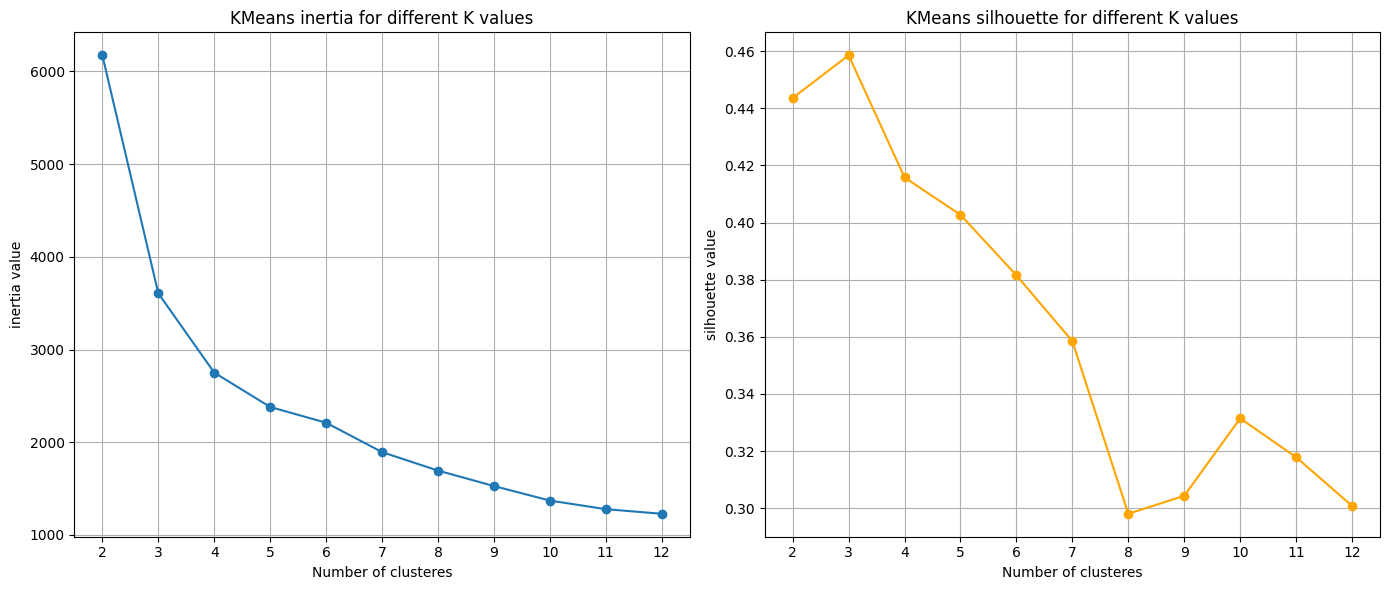

In [48]:
max_clusters = 12

inertia_values = []
silhouette_scores = []
k_values = range(2, max_clusters + 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    
    cluster_labels = kmeans.fit_predict(scaled_df)

    sil_score = silhouette_score(scaled_df, cluster_labels)
    silhouette_scores.append(sil_score)
    
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(k_values, inertia_values, marker = 'o')
plt.title("KMeans inertia for different K values")
plt.xlabel("Number of clusteres")
plt.ylabel("inertia value")
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(k_values, silhouette_scores, marker = 'o', color = 'orange')
plt.title("KMeans silhouette for different K values")
plt.xlabel("Number of clusteres")
plt.ylabel("silhouette value")
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

In [50]:

Kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
cluster_labels = Kmeans.fit_predict(scaled_df)
cluster_labels

array([1, 0, 2, ..., 1, 0, 0], shape=(3809,), dtype=int32)

In [51]:
no_outliers_df["cluster"] = cluster_labels
no_outliers_df

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_10988\1869800415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outliers_df["cluster"] = cluster_labels


,Customer ID,CustomerTotalPurchase,Frequency,LastInvoiceDate,recency,cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00,17,0
4281,18284.00,411.68,1,2010-10-04 11:33:00,66,2
4282,18285.00,377.00,1,2010-02-17 10:24:00,295,1
4283,18286.00,1246.43,2,2010-08-20 11:57:00,111,0


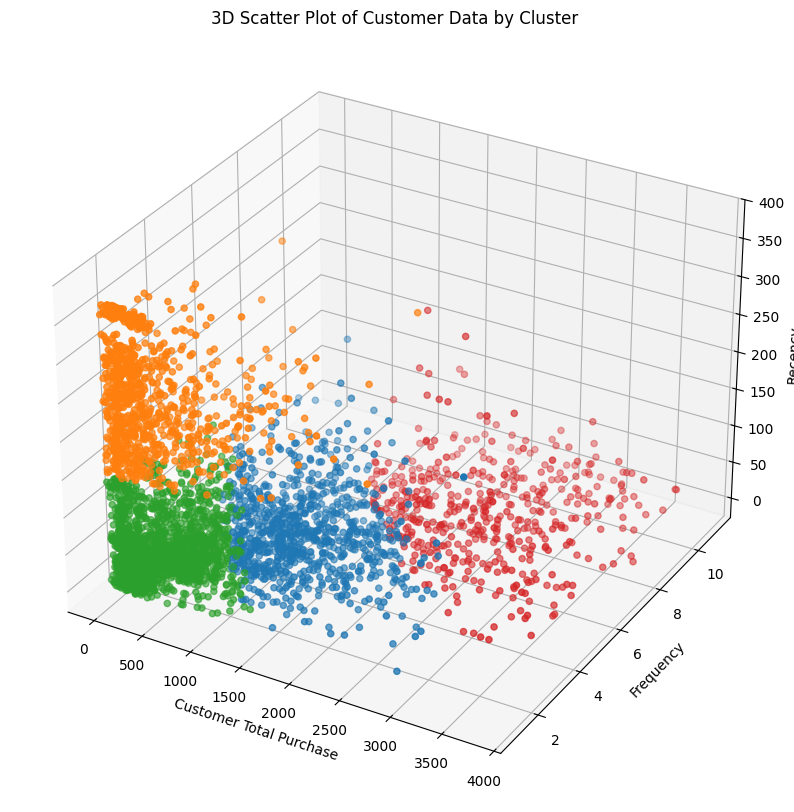

In [53]:
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = no_outliers_df['cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(no_outliers_df['CustomerTotalPurchase'], 
                     no_outliers_df['Frequency'], 
                     no_outliers_df['recency'], 
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Customer Total Purchase')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

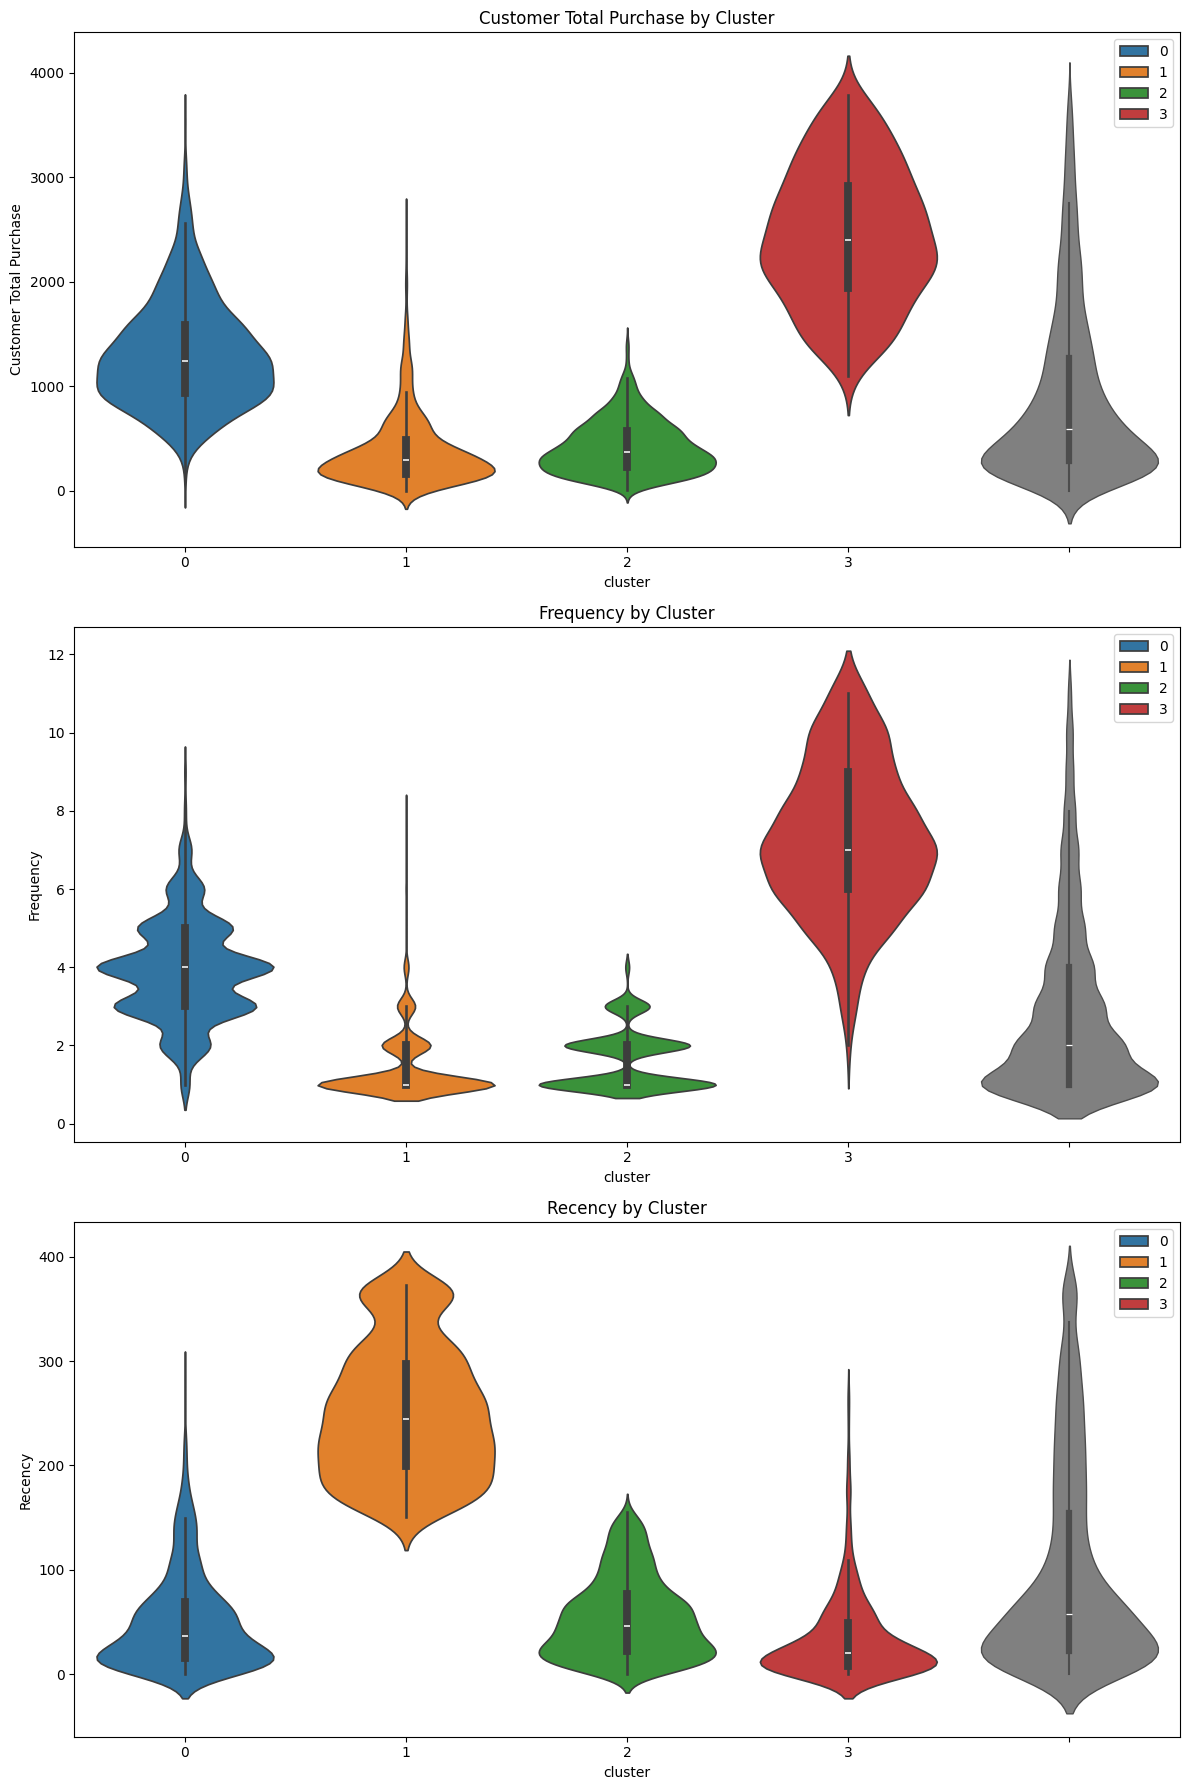

In [56]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=no_outliers_df['cluster'], y=no_outliers_df['CustomerTotalPurchase'], palette=cluster_colors, hue=no_outliers_df["cluster"])
sns.violinplot(y=no_outliers_df['CustomerTotalPurchase'], color='gray', linewidth=1.0)
plt.title('Customer Total Purchase by Cluster')
plt.ylabel('Customer Total Purchase')

plt.subplot(3, 1, 2)
sns.violinplot(x=no_outliers_df['cluster'], y=no_outliers_df['Frequency'], palette=cluster_colors, hue=no_outliers_df["cluster"])
sns.violinplot(y=no_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=no_outliers_df['cluster'], y=no_outliers_df['recency'], palette=cluster_colors, hue=no_outliers_df["cluster"])
sns.violinplot(y=no_outliers_df['recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [59]:
overlap_indices = purchase_outliers.index.intersection(frequency_outliers.index)

purchase_only_outliers = purchase_outliers.drop(overlap_indices)
frequency_only_outliers = frequency_outliers.drop(overlap_indices)
purchase_and_frequency_outliers = purchase_outliers.loc[overlap_indices]

purchase_only_outliers["cluster"] = -1
frequency_only_outliers["cluster"] = -2
purchase_and_frequency_outliers["cluster"] = -3

outlier_clusters_df = pd.concat([purchase_only_outliers, frequency_only_outliers, purchase_and_frequency_outliers])

outlier_clusters_df

,Customer ID,CustomerTotalPurchase,Frequency,LastInvoiceDate,recency,cluster
9,12357.00,11229.99,1,2010-11-16 10:05:00,23,-1
25,12380.00,4782.84,4,2010-08-31 14:54:00,100,-1
42,12409.00,12346.62,4,2010-10-15 10:24:00,55,-1
48,12415.00,19468.84,4,2010-11-29 15:07:00,10,-1
61,12431.00,4145.52,11,2010-12-01 10:03:00,8,-1
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3


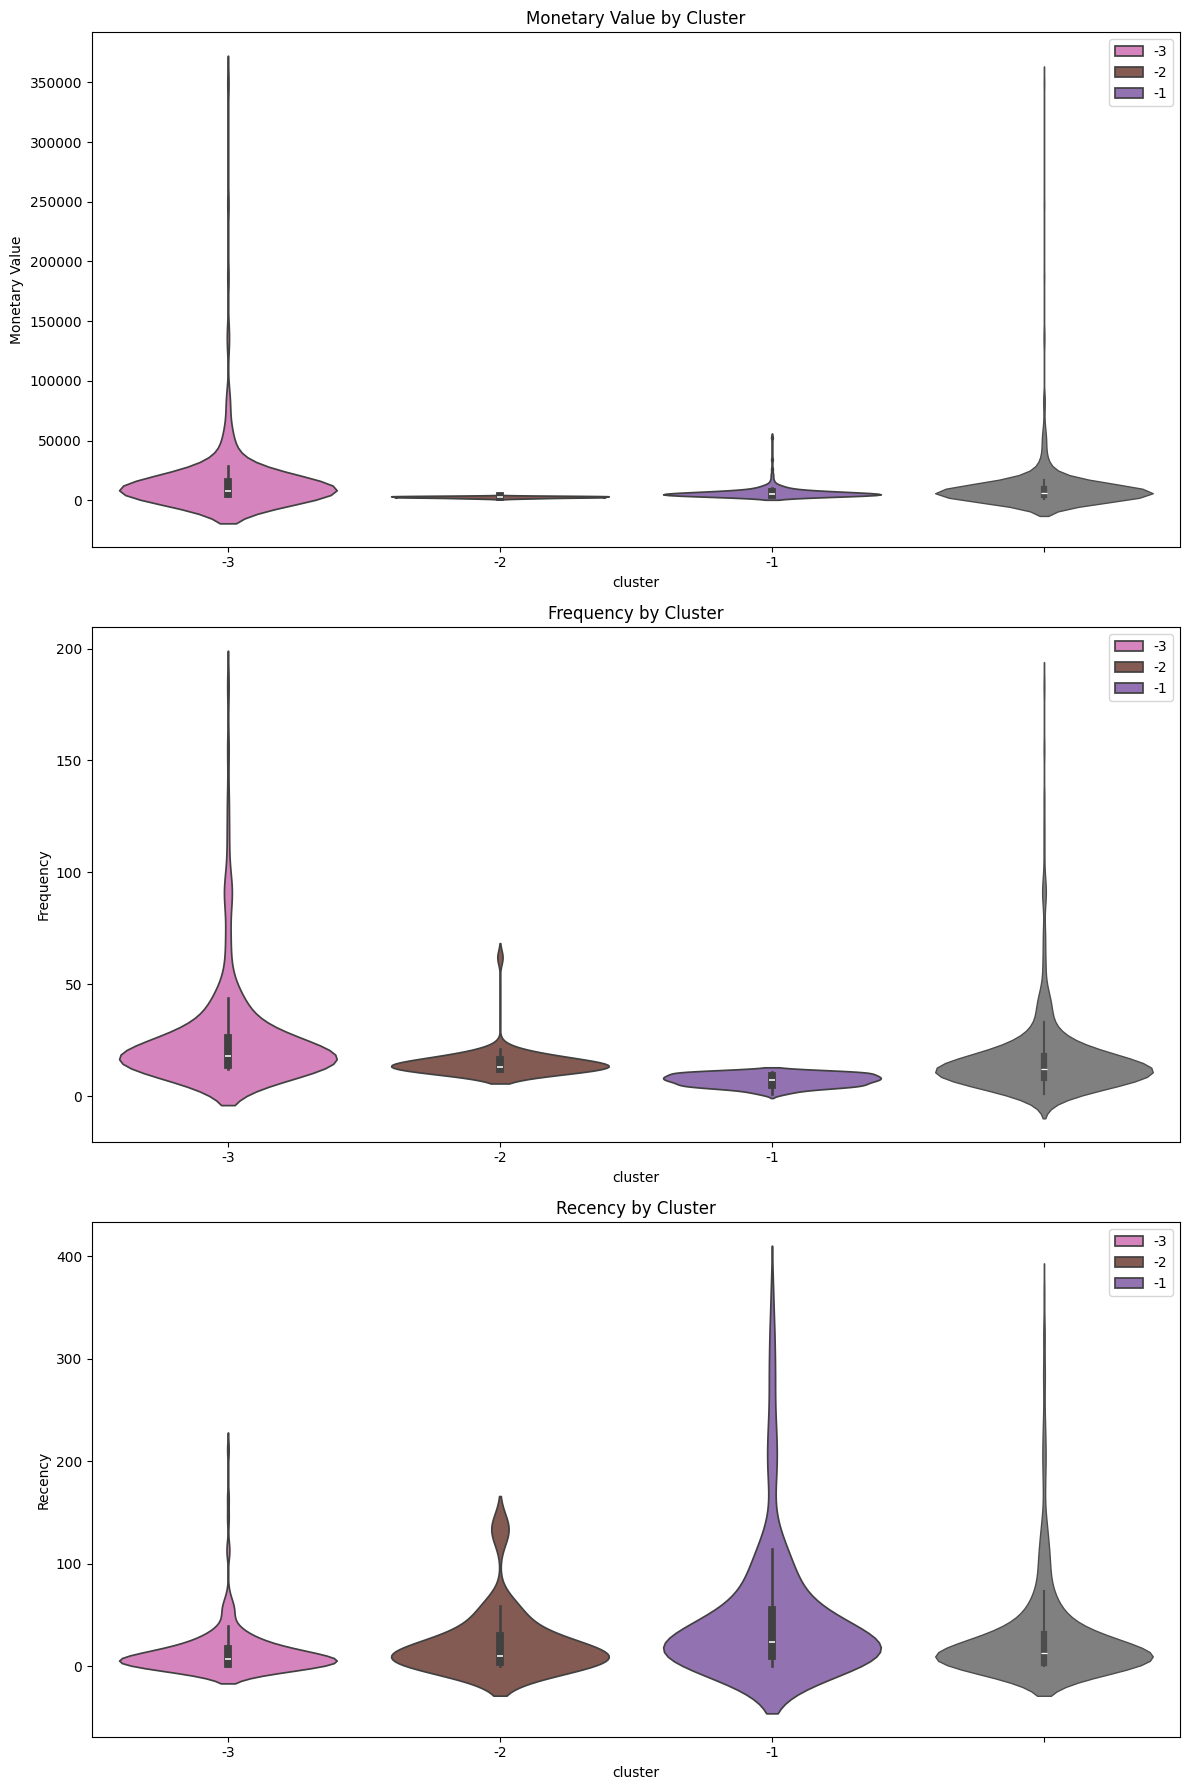

In [60]:
cluster_colors = {-1: '#9467bd',
                  -2: '#8c564b',
                  -3: '#e377c2'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['cluster'], y=outlier_clusters_df['CustomerTotalPurchase'], palette=cluster_colors, hue=outlier_clusters_df["cluster"])
sns.violinplot(y=outlier_clusters_df['CustomerTotalPurchase'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['cluster'], y=outlier_clusters_df['recency'], palette=cluster_colors, hue=outlier_clusters_df["cluster"])
sns.violinplot(y=outlier_clusters_df['recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [61]:
cluster_labels = {
    0: "RETAIN",
    1: "RE-ENGAGE",
    2: "NURTURE",
    3: "REWARD",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "DELIGHT"
}

full_clustering_df = pd.concat([no_outliers_df, outlier_clusters_df])

full_clustering_df

,Customer ID,CustomerTotalPurchase,Frequency,LastInvoiceDate,recency,cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3


In [63]:

full_clustering_df["ClusterLabel"] = full_clustering_df["cluster"].map(cluster_labels)

full_clustering_df

,Customer ID,CustomerTotalPurchase,Frequency,LastInvoiceDate,recency,cluster,ClusterLabel
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1,RE-ENGAGE
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0,RETAIN
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2,NURTURE
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0,RETAIN
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2,NURTURE
...,...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3,DELIGHT
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3,DELIGHT
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3,DELIGHT
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3,DELIGHT


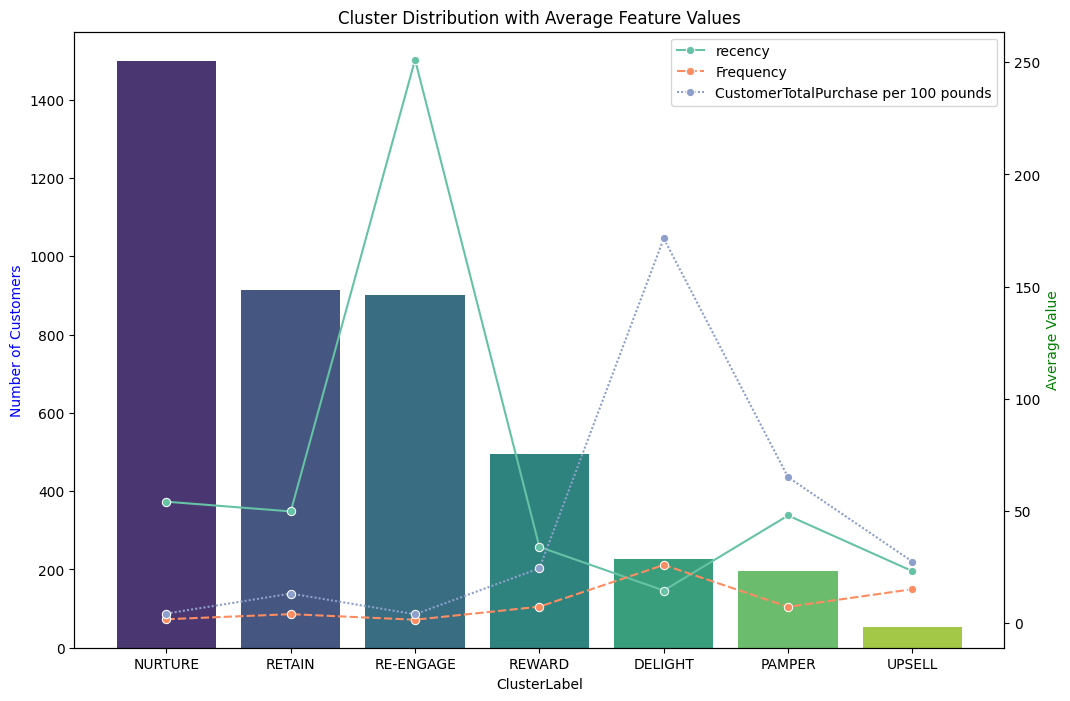

In [65]:
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()
full_clustering_df["CustomerTotalPurchase per 100 pounds"] = full_clustering_df["CustomerTotalPurchase"] / 100.00
feature_means = full_clustering_df.groupby('ClusterLabel')[['recency', 'Frequency', 'CustomerTotalPurchase per 100 pounds']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()